# Collaborative filtering using graphical models

In the Yelp dataset, consider each restaurant r to have a latent trait t_r, let each user u have a latent preference pu, let the user’s experience at a restaurant be X_u,r = Normal(t_r * p_u, 1), and suppose the user gives a rating of
two or more stars if X_u,r > 0. Use Gibbs sampling to learn the latent variables t_r and p_u.

In [101]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
import pandas as pd

In [30]:
# Generate synthetic dataset 
R = 100
U = 500
reviews = list()

for user in range(U):
    num = np.random.choice(range(1, 70), 1)
    num = num[0]
    restaurants = np.random.choice(R, num, replace=False)
    for restaurant in restaurants:
        rating = np.random.choice([-1, 1], 1)
        reviews = reviews + [[user, restaurant, rating[0]]]

N = len(reviews)
reviews = np.array(reviews)


# Process Yelp Dataset

In [102]:
# Import dataset
reviews_df = pd.read_csv("Users200reviews/reviews.csv")
users_df = pd.read_csv("Users200reviews/users.csv")
restaurants_df = pd.read_csv("Users200reviews/business.csv")


In [103]:
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)
R = restaurants_df.values.shape[0]
U = users_df.values.shape[0]

print R
print U

442
1013


In [104]:
reviews = np.array(reviews_df[['user_id', 'business_id', 'stars']].values)

for review in reviews:
    review[0] = users_df.index[users_df.id == review[0]].values[0]
    review[1] = restaurants_df.index[restaurants_df.id == review[1]].values[0]
reviews = reviews.astype(int)

In [105]:
reviews.shape

(14627, 3)

In [109]:
users_df.get_value(3, 'id')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


'-FZBTkAZEXoP7CYvRV2ZwQ'

# Visualize data

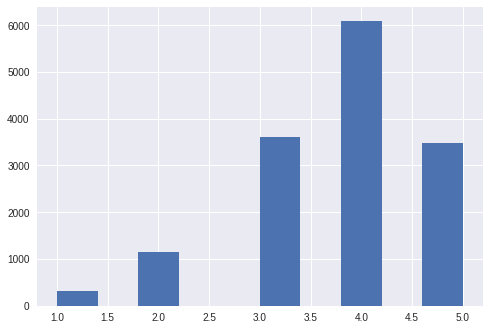

In [110]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(reviews_df['stars'].values)
plt.show()

# Modeling a single trait and a binary outcome

Assumptions:

    1) Each restaurant can be characterised by its position on the trait line (represented as a continuous number).
    
    2) Each person's preference can be characterised by its position on the trait line (represented as a continuous number).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.

Perform Gibbs sampling:
    
    1) Sample user experience X from conditional posterior
    
    2) Jointly sample restaurant traits from conditional posterior
    
    3) Jointly sample user preferences from conditional posterior

In [120]:
def rejection_sampling(mu, std, rating):
    if rating>3:
        sign = 1
    else: 
        sign = -1
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if np.sign(x)==sign:
            return x
    

def Gibbs_sampling_single_trait_binary_rating(reviews):

    pv_t = np.ones(R)   # prior variance for restaurant traits
    t = np.zeros(R)     # restaurant traits, initialized to be the prior mean miu_0 = 0

    pv_p = np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean miu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(2500):
        
        if num%250==0:
            print num
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t) and rating (r)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling(s, 1, reviews[r][2])
        #print x
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        #print x, p
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [145]:
train_reviews = reviews[:12000]
test_reviews = reviews[12000:]

In [146]:
restaurant_traits_samples, user_preferences_samples = Gibbs_sampling_single_trait_binary_rating(train_reviews)

0
250
500
750
1000
1250
1500
1750
2000
2250


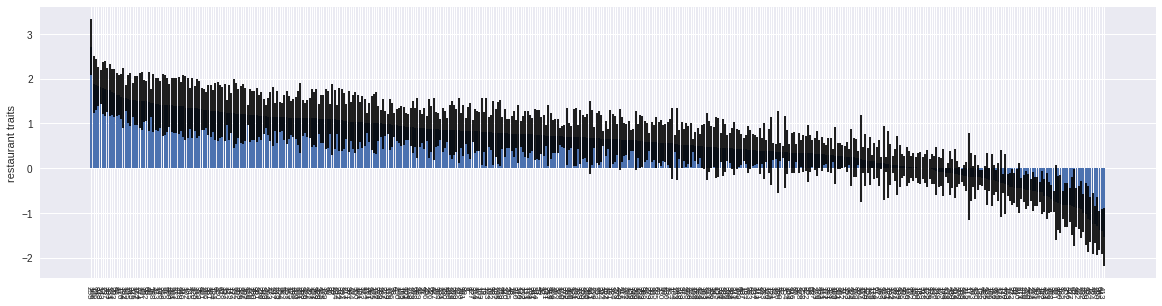

In [147]:
mean_traits = np.mean(restaurant_traits_samples, axis=0)
std_traits = np.std(restaurant_traits_samples, axis=0)
rank_order = np.argsort(mean_traits)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(R)
    plt.bar(x, mean_traits[rank_order], align='center', width=.8, yerr=std_traits[rank_order])
    plt.xticks(x, rank_order, rotation=-90, ha='right')
    plt.ylabel('restaurant traits')
plt.show()

In [ ]:
plt.scatter(mean_trais)
plt.show()

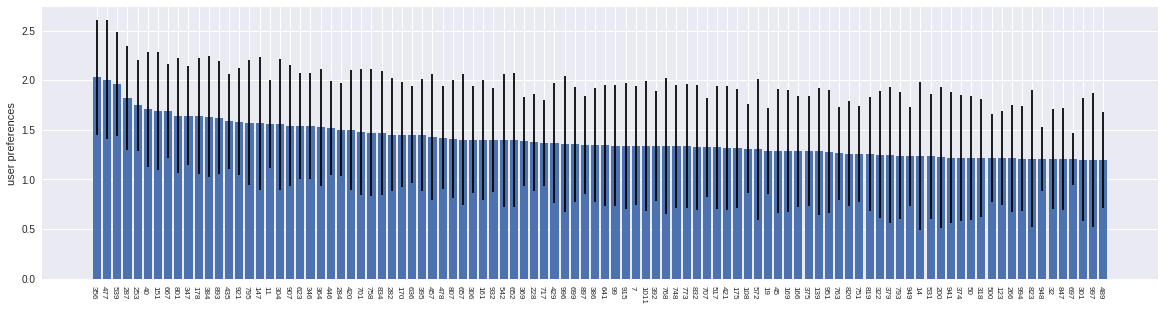

In [148]:
mean_preferences = np.mean(user_preferences_samples, axis=0)
std_preferences = np.std(user_preferences_samples, axis=0)
rank_order = np.argsort(mean_preferences)[::-1]
rank_order = rank_order[:100]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_preferences[rank_order], align='center', width=.8, yerr=std_preferences[rank_order])
    plt.xticks(x, rank_order, rotation=-90, ha='right')
    plt.ylabel('user preferences')
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


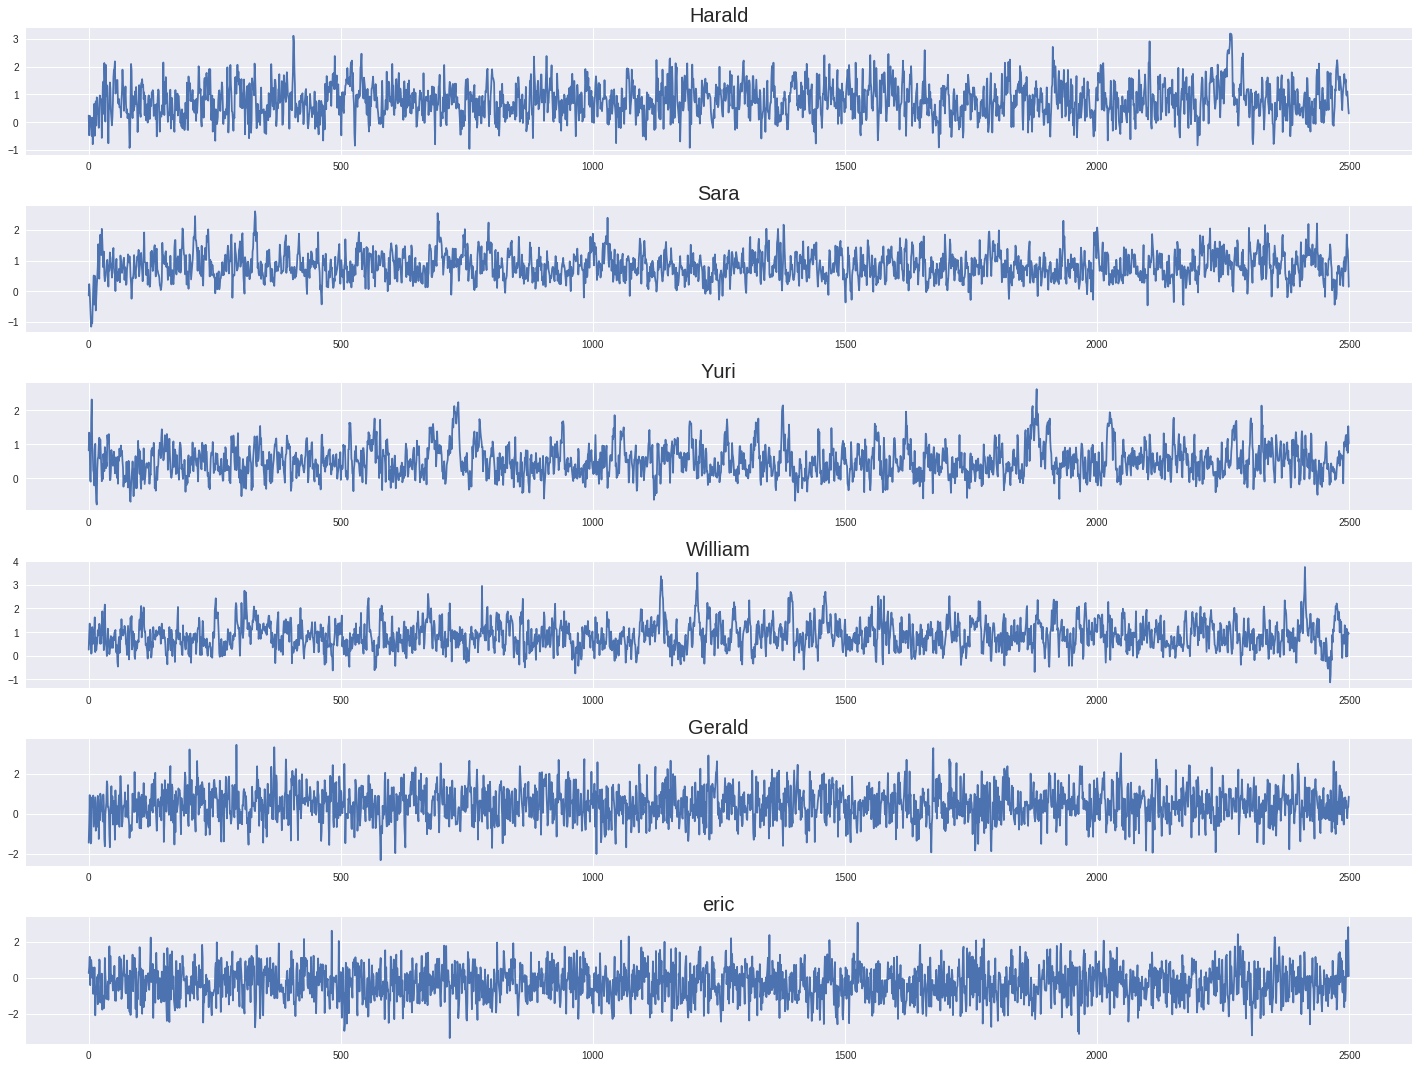

In [149]:
users = [0, 1, 2, 3, 4, 5, 6]

with matplotlib.rc_context({'figure.figsize': [20,15], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(6):
        ax = fig.add_subplot(6, 1, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.plot(user_preferences_samples[:, users[i]])
        ax.set_title(users_df.get_value(users[i], 'name'))
plt.show()

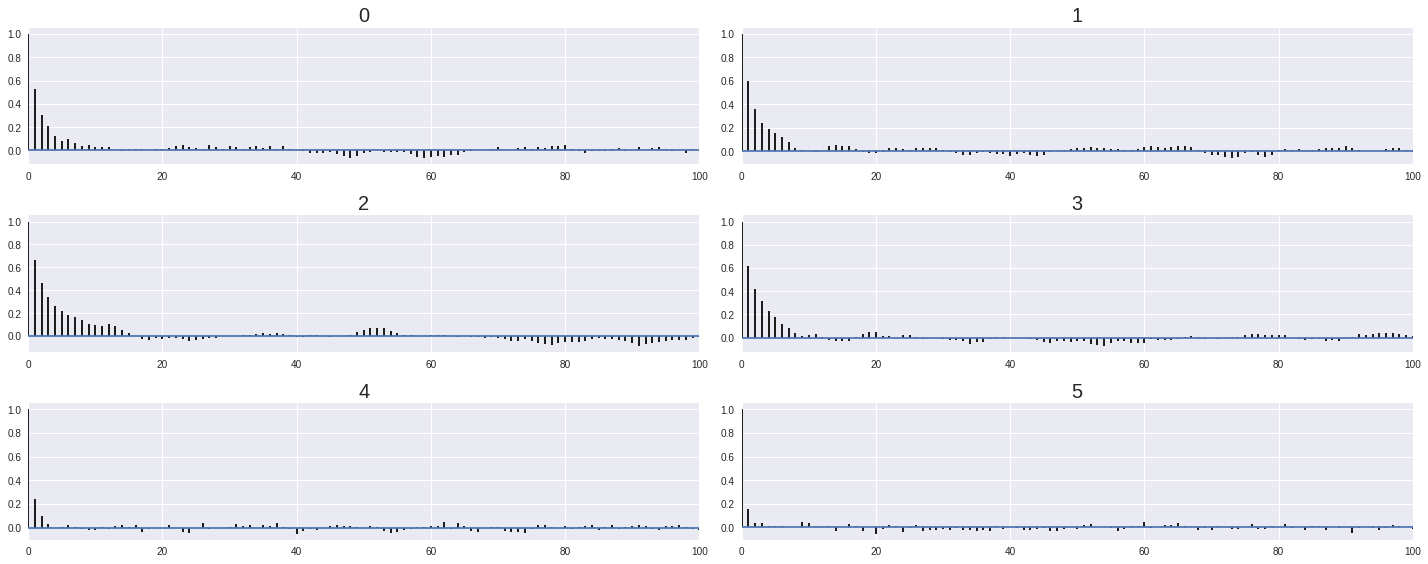

In [150]:
with matplotlib.rc_context({'figure.figsize': [20,8], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(6):
        ax = fig.add_subplot(3, 2, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.acorr(user_preferences_samples[:, users[i]] - np.mean(user_preferences_samples[:, users[i]]), maxlags=100)
        ax.set_title(users[i])
        ax.set_xlim(0,100)
plt.show()

# Evaluate performance

In [152]:
test_reviews = reviews
num_test_reviews = test_reviews.shape[0]
num = 0
for test_review in test_reviews:
    user_preference = mean_preferences[test_review[0]]
    restaurant_trait = mean_traits[test_review[1]]
    experience = user_preference * restaurant_trait
    
    if test_review[2] > 3:
        sign = 1
    else:
        sign = -1
    
    if np.sign(experience) == sign:
        num = num + 1

print float(float(num)/float(num_test_reviews))
    

0.718670950981


# Modeling multiple traits and a binary outcome

Assumptions:

    1) Each restaurant can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    2) Each person's preference can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) The effect of one trait value on whether a person likes or dislikes a restaurant is the same, no matter what other trait values that restaurant has.
    
    5) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.

Perform Gibbs sampling:
    
    1) Sample user experience X from conditional posterior
    
    2) Jointly sample restaurant traits from conditional posterior
    
    3) Jointly sample user preferences from conditional posterior

# Modeling multiple traits and star ratings

Assumptions:

    1) Each restaurant can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    2) Each person's preference can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) The effect of one trait value on whether a person likes or dislikes a restaurant is the same, no matter what other trait values that restaurant has.
    
    5) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.
    
    6) When two people have the same user experience for a restaurant, they will give it the same number of stars.